# Lab 4: Data Imputation using an Autoencoder

**Deadline**: Thursday, March 5, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Chris Lucasius

In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


# Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1JTip_JqSTZ_OGPehxclgLind5ldsyZKM

# Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import pandas as pd

In [0]:
import csv
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import os
from torchvision import datasets, models, transforms
import torch.utils.data
import math # for doing floor/ceiling calculations
import time # for finding runtime
import matplotlib.pyplot as plt # for plotting
from sklearn import preprocessing # for normalization

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [0]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

In [0]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [0]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


In [0]:
# min, max, average value across the columns age, yredu, capgain, caploss, workhr
the_columns = ["age", "yredu", "capgain", "caploss", "workhr"]

def print_statements(df, column_name):
    print("min value in {}: {}".format(column_name, df[column_name].min()))
    print("max value in {}: {}".format(column_name, df[column_name].max()))
    print("avg value in {}: {}\n".format(column_name, df[column_name].mean()))

for category in the_columns:
    print(category, "min/max/average info:")
    print_statements(df, category)

age min/max/average info:
min value in age: 17
max value in age: 90
avg value in age: 38.58164675532078

yredu min/max/average info:
min value in yredu: 1
max value in yredu: 16
avg value in yredu: 10.0806793403151

capgain min/max/average info:
min value in capgain: 0
max value in capgain: 99999
avg value in capgain: 1077.6488437087312

caploss min/max/average info:
min value in caploss: 0
max value in caploss: 4356
avg value in caploss: 87.303829734959

workhr min/max/average info:
min value in workhr: 1
max value in workhr: 99
avg value in workhr: 40.437455852092995



In [0]:
# normalize features ["age", "yredu", "capgain", "caploss", "workhr"] to between 0 and 1 
def normalize(dataset):
    # there are some features that we don't want to normalize, so copy those features into the normalized array first
    dataNorm = dataset

    # normalize certain features to be between 0 and 1
    to_normalize = ["age", "yredu", "capgain", "caploss", "workhr"]
    for category in to_normalize:
        dataNorm[category]=((dataset[category] - dataset[category].min()) / (dataset[category].max() - dataset[category].min()))
    return dataNorm

df = normalize(df)
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,0.301370,State-gov,77516,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,83311,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.0,0.122449,United-States
2,0.287671,Private,215646,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.00000,0.0,0.397959,United-States


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [0]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,0.301370,0.800000,0.02174,0.0,0.397959
1,0.452055,0.800000,0.00000,0.0,0.122449
2,0.287671,0.533333,0.00000,0.0,0.397959


Numpy works nicely with pandas, like below:

In [0]:
np.sum(subdf["caploss"])

652.5941230486685

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1` 

would increment everyone's age by 1.

### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [0]:
# hint: you can do something like this in pandas
print("Percentage of male data samples:", sum(df["sex"] == " Male") / df.shape[0])
print("Percentage of felame data samples:", sum(df["sex"] == " Female") / df.shape[0])

Percentage of male data samples: 0.6692054912318418
Percentage of felame data samples: 0.33079450876815825


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [0]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [0]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

print("Number of records in df_not_missing:", len(df_not_missing))
print("Number of records in df_with_missing:", len(df_with_missing))

print("Number of records containing missing features:", len(df_with_missing))
print("Percentage of records removed:", len(df_with_missing) / (len(df_not_missing) + len(df_with_missing)))

Number of records in df_not_missing: 30718
Number of records in df_with_missing: 1843
Number of records containing missing features: 1843
Percentage of records removed: 0.056601455729246644


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [0]:
print("Possible values of 'work' in df_not_missing:", set(df_not_missing["work"]))

Possible values of 'work' in df_not_missing: {' Self-emp-inc', ' Without-pay', ' State-gov', ' Federal-gov', ' Private', ' Self-emp-not-inc', ' Local-gov'}


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [0]:
data = pd.get_dummies(df_not_missing)

In [0]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,work_ State-gov,work_ Without-pay,marriage_ Divorced,marriage_ Married-AF-spouse,marriage_ Married-civ-spouse,marriage_ Married-spouse-absent,marriage_ Never-married,marriage_ Separated,marriage_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,edu_ 10th,edu_ 11th,edu_ 12th,edu_ 1st-4th,edu_ 5th-6th,edu_ 7th-8th,edu_ 9th,edu_ Assoc-acdm,edu_ Assoc-voc,edu_ Bachelors,edu_ Doctorate,edu_ HS-grad,edu_ Masters,edu_ Preschool,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [0]:
print("Number of columns in 'data':", data.shape[1])
# There are 57 categories in the dataframe when you expand the different options for 
# 'age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
# 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country'

# When you apply one-hot encoding, all of the sub-categories under the features 'age', 'work', 'fnlwgt', 'edu', 
# 'yredu', 'marriage', 'occupation', 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country'
# need to be expanded to indicate whether a person has one of these categories that existed as strings under 
# the un-normalized data structure where one-hot encoding is not applied. 

Number of columns in 'data': 57


### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [0]:
datanp = data.values.astype(np.float32)

In [0]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """

    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values` 
    # (created above) useful.

    # find the index in the array that has the max value
    max_value_index = np.argmax(onehot)
    #print(max_value_index) # testing

    # return the max_value_index'th element of the subarray containing the feature
    feature_types = cat_values[feature][max_value_index] # feature_types contains the possible values that 'feature' can take on
    return feature_types

In [0]:
# testing for functionality
print(get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")) # should print 'State-gov'
print(get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")) # should print 'Private'

State-gov
Private


In [0]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [0]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
import math

np.random.seed(50) # seed random function for reproducible shuffling
np.random.shuffle(datanp)

num_data_samples = len(datanp)
last_train_sample = math.floor(num_data_samples * 0.7)
last_val_sample = last_train_sample + math.ceil(num_data_samples * 0.15)

train_data = datanp[:last_train_sample]
val_data = datanp[last_train_sample:last_val_sample]
test_data = datanp[last_val_sample:]

print("Number of training samples:", len(train_data))
print("Number of validation samples:", len(val_data))
print("Number of testing samples:", len(test_data))

Number of training samples: 21502
Number of validation samples: 4608
Number of testing samples: 4608


In [0]:
def get_data_loader(train_data, val_data, test_data, batch_size):
    num_workers = 1
    np.random.seed(50) 
    trainLoader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    valLoader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    testLoader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

    return trainLoader, valLoader, testLoader

In [0]:
# check that data is loaded properly
trainLoader, valLoader, testLoader = get_data_loader(train_data, val_data, test_data, 32)
dataiter = iter(trainLoader)
sample_data = dataiter.next()
print(sample_data)

tensor([[0.0411, 0.6000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.1918, 0.5333, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        [0.0959, 0.6000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.4932, 0.4000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.1781, 0.5333, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        [0.0685, 0.6000, 0.0000,  ..., 1.0000, 1.0000, 0.0000]])


# Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [0]:
from torch import nn

# FULLY CONNECTED AUTOENCODER -> NO CONVOLUTIONAL LAYERS

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.name = "Autoencoder"
        encoding_dim = 32
        
        self.encoder = nn.Sequential(
            nn.Linear(57, encoding_dim) # TODO -- FILL OUT THE CODE HERE!
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 57), # TODO -- FILL OUT THE CODE HERE!
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

In [0]:
"""
The sigmoid function restricts the output to a value between 0 and 1. Since we normalized the features
["age", "yredu", "capgain", "caploss", "workhr"] to have values between 0 and 1, the output of our model
should be a number within this normalized range when it makes a prediction for a missing value.
"""

# Part 3. Training [18] 


### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [0]:
# helper functions
def get_model_name(name, learning_rate, batch_size, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
    return path

def plot_graph(graph_title, x_label, y_label, num_epochs, training_data, val_data, testing_data = None):
    plt.figure()
    plt.title(graph_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    plt.plot(range(1,num_epochs+1), training_data, label="Training")
    plt.plot(range(1,num_epochs+1), val_data, label="Validation")

    if testing_data != None:
        plt.plot(range(1,num_epochs+1), testing_data, label="Testing")
    plt.legend()
    plt.show()

def plot_acc_and_loss(num_epochs, train_err, val_err, train_loss, val_loss):
    print("\n-------------------------------------GRAPHS-------------------------------------\n")
    print("Accuracy plot of Lab4 Autoencoder")   
    plot_graph("Accuracy", "Number of Epochs", "Accuracy", num_epochs, train_err, val_err)

    print("Loss plot of Lab4 Autoencoder")   
    plot_graph("Loss", "Number of Epochs", "Loss", num_epochs, train_loss, val_loss)

def plot_train_only(num_epochs, train_err, train_loss):
    plt.figure()
    plt.title("Accuracy")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy")
    
    plt.plot(range(1,num_epochs+1), train_err, label="Training")
    
    plt.legend()
    plt.show()

    plt.figure()
    plt.title("Loss")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss")
    
    plt.plot(range(1,num_epochs+1), train_loss, label="Training")
    
    plt.legend()
    plt.show()

In [0]:
# functions for removing features
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

In [0]:
def train(model, train_loader, val_loader, learning_rate=1e-4, batch_size = 64, num_epochs=30):
    """ Training loop. You should update this."""
    torch.manual_seed(50)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_err = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)

    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    start_time = time.time()

    for epoch in range(num_epochs):
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_err[epoch] = get_accuracy(model, train_loader)
        train_loss[epoch] = loss

        if val_loader != None: # for overfitting, val_loader isn't passed in
            for data in val_loader:
                datam = zero_out_random_feature(data.clone()) # zero out one categorical feature            
                recon = model(datam)
                loss_val = criterion(recon, data)
                optimizer.step()
                optimizer.zero_grad()

            val_err[epoch] = get_accuracy(model, val_loader)
            val_loss[epoch] = loss_val

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, learning_rate, batch_size, epoch)
        torch.save(model.state_dict(), model_path)

    end_time = time.time()

    print('Finished Training')
    
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    if val_loader != None: # for overfitting, val_loader isn't passed in
        print("\n------------------------------------TRAINING------------------------------------")
        print("Training accuracy after {} epochs: {}".format(num_epochs, train_err[-1]))
        print("Training loss after {} epochs: {}".format(num_epochs, train_loss[-1]))
        print("\n-----------------------------------VALIDATION-----------------------------------")
        print("Validation accuracy after {} epochs: {}".format(num_epochs, val_err[-1]))
        print("Validation loss after {} epochs: {}".format(num_epochs, val_loss[-1]))
        return num_epochs, train_err, train_loss, val_err, val_loss
    else:
        print("\n------------------------------------TRAINING------------------------------------")
        print("Training accuracy after {} epochs: {}".format(num_epochs, train_err[-1]))
        print("Training loss after {} epochs: {}".format(num_epochs, train_loss[-1]))
        return num_epochs, train_err, train_loss

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [0]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

In [0]:
# testing if the model can overfit to a small dataset
#train_loader, val_loader, test_loader = get_data_loader(train_data, val_data, test_data, batch_size = 11)
#model = AutoEncoder()
#num_epochs, train_err, train_loss = train(model, train_loader, val_loader = None, num_epochs=30)
#plot_train_only(num_epochs, train_err, train_loss)

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

Finished Training
Total time elapsed: 193.41 seconds

------------------------------------TRAINING------------------------------------
Training accuracy after 30 epochs: 0.6413124360524602
Training loss after 30 epochs: 0.020155884325504303

-----------------------------------VALIDATION-----------------------------------
Validation accuracy after 30 epochs: 0.6349103009259259
Validation loss after 30 epochs: 0.01621781289577484

-------------------------------------GRAPHS-------------------------------------

Accuracy plot of Lab4 Autoencoder


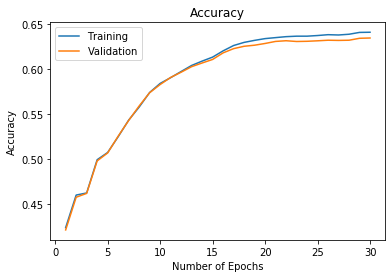

Loss plot of Lab4 Autoencoder


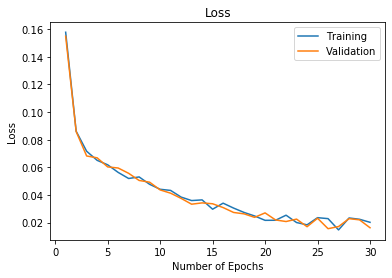

In [0]:
# default/initial hyperparameters:
# number of layers: 2
# dimension of encoding layer: 32x32
# batch size: 64
# learning rate: 0.0001
# number of epochs: 30

train_loader, val_loader, test_loader = get_data_loader(train_data, val_data, test_data, batch_size = 64)
model = AutoEncoder()
num_epochs, train_err, train_loss, val_err, val_loss = train(model, train_loader, val_loader)
plot_acc_and_loss(num_epochs, train_err, val_err, train_loss, val_loss)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

In [0]:
"""
------------------------------------Default------------------------------------
Default hyperparameter values:
    - number of layers: 2 layers
    - dimension of embedding layer: 32x32
    - batch size: 64
    - learning rate: 0.0001
    - number of epochs: 30
This allowed my autoencoder model to achieve a training accuracy of 0.641 and a validation accuracy of 0.635.

------------------------------------Test 1------------------------------------
The first hyperparameter I changed was the dimension of the embedding layer, decreasing it from 32x32 to 16x16. I did this 
because I thought it would force the autoencoder to be more specific in which values it chose to be important, and to keep 
in the low-dimensional embedding. The ultimate goal is to train the autoencoder to recognize which feature values are important 
in making an accurate prediction. I kept all other hyperparameter values the same. With the first set of values, I achieved a 
training accuracy of 0.645 and a validation accuracy of 0.639.

Hyperparameter values:
    - number of layers: 2
    - dimension of embedding layer: 16x16
    - batch size: 64
    - learning rate: 0.0001
    - number of epochs: 30

------------------------------------Test 2------------------------------------
The results of Test 1 demonstrated that the model experienced more overfitting compared to the default model, since the training 
accuracy is higher but the validation accuracy is lower. To reduce the likelihood of overfitting, I decided to increase the 
learning rate from 0.0001 to 0.001, while keeping the dimensions of the embedding layer as 32x32. This second set of values 
produced a training accuracy of 0.654 and a validation accuracy of 0.651. 

Hyperparameter values:
    - number of layers: 2
    - dimension of embedding layer: 16x16
    - batch size: 64
    - learning rate: 0.001
    - number of epochs: 30

------------------------------------Test 3------------------------------------
The accuracy values of Test 2 are both higher than the default set’s accuracy. Furthermore, the loss values generated by Test 2 
are both lower than in the default set. Overall, this shows that the hyperparameter values chosen in Test 2 were a good fit to 
the data. In Test 3, I decided to decrease the batch size from 64 to 32, while keeping all other hyperparameter values the same 
as in Test 2. This produced a training accuracy of 0.661 and a validation accuracy of 0.657.

Hyperparameter values:
    - number of layers: 2
    - dimension of embedding layer: 16x16
    - batch size: 32
    - learning rate: 0.001
    - number of epochs: 30

------------------------------------Test 4------------------------------------
As a last hyperparameter test, I wanted to see whether the high accuracy achieved in the last test was more influenced by the 
batch size or the dimension of the encoding layer. From Test 2, I learned that a learning rate of 0.001 produced higher accuracies 
than a learning rate of 0.0001 when the batch size was 64. From Test 3, I learned that lowering the batch size from 64 to 32 
produced higher accuracies than in Test 2. However, the difference between the training and validation loss was greater in Test 3 
than Test 2, indicating more overfitting in Test 3 than in Test 2. I wanted to reduce this overfitting, and Test 2 indicated that 
setting the encoding dimension to 32 seems to reduce the likelihood of overfitting. The hyperparameter values I used in Test 4 are 
the same as the values in Test 2, except the dimension of the embedding layer was increased to 32x32. This produced a training 
accuracy of 0.668 and a validation accuracy of 0.661. 


Hyperparameter values:
    - number of layers: 2
    - dimension of embedding layer: 32x32
    - batch size: 64
    - learning rate: 0.001
    - number of epochs: 30

---------------------------------Adding More Layers---------------------------------
As a side note, I also tried adding more fully-connected layers by adding a hidden layer with 40 units, connected to the input 
layer through a ReLU activation function, but this produced a training accuracy of 0.657 and a validation accuracy of 0.630. 
Furthermore, the training loss was 0.006 and the validation loss was 0.015, which indicated overfitting compared to other 
test models. 
"""

In [0]:
# test 1:
train_loader, val_loader, test_loader = get_data_loader(train_data, val_data, test_data, batch_size = 64)
model = AutoEncoder()
num_epochs, train_err, train_loss, val_err, val_loss = train(model, train_loader, val_loader, learning_rate=0.0001, num_epochs=30)

Finished Training
Total time elapsed: 198.71 seconds

------------------------------------TRAINING------------------------------------
Training accuracy after 30 epochs: 0.6453508200787523
Training loss after 30 epochs: 0.02087388187646866

-----------------------------------VALIDATION-----------------------------------
Validation accuracy after 30 epochs: 0.6393229166666666
Validation loss after 30 epochs: 0.023538555949926376


In [0]:
# test 2:
train_loader, val_loader, test_loader = get_data_loader(train_data, val_data, test_data, batch_size = 64)
model = AutoEncoder()
num_epochs, train_err, train_loss, val_err, val_loss = train(model, train_loader, val_loader, learning_rate=0.001, num_epochs=30)

Finished Training
Total time elapsed: 184.67 seconds

------------------------------------TRAINING------------------------------------
Training accuracy after 30 epochs: 0.6537996465445075
Training loss after 30 epochs: 0.016462476924061775

-----------------------------------VALIDATION-----------------------------------
Validation accuracy after 30 epochs: 0.6513671875
Validation loss after 30 epochs: 0.013677151873707771


In [0]:
# test 3:
train_loader, val_loader, test_loader = get_data_loader(train_data, val_data, test_data, batch_size = 32)
model = AutoEncoder()
num_epochs, train_err, train_loss, val_err, val_loss = train(model, train_loader, val_loader, learning_rate=0.001, num_epochs=30)

Finished Training
Total time elapsed: 294.08 seconds

------------------------------------TRAINING------------------------------------
Training accuracy after 30 epochs: 0.6616051220041547
Training loss after 30 epochs: 0.006747652776539326

-----------------------------------VALIDATION-----------------------------------
Validation accuracy after 30 epochs: 0.6569372106481481
Validation loss after 30 epochs: 0.01581755094230175


Finished Training
Total time elapsed: 190.79 seconds

------------------------------------TRAINING------------------------------------
Training accuracy after 30 epochs: 0.6682479149226429
Training loss after 30 epochs: 0.014000440016388893

-----------------------------------VALIDATION-----------------------------------
Validation accuracy after 30 epochs: 0.6605902777777778
Validation loss after 30 epochs: 0.013958047144114971

-------------------------------------GRAPHS-------------------------------------

Accuracy plot of Lab4 Autoencoder


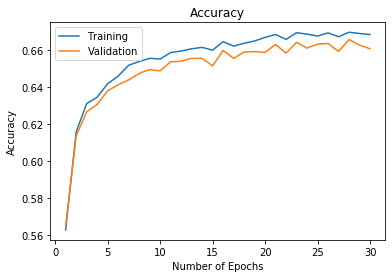

Loss plot of Lab4 Autoencoder


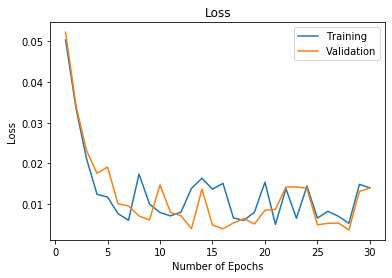

In [0]:
# test 4:
train_loader, val_loader, test_loader = get_data_loader(train_data, val_data, test_data, batch_size = 64)
model = AutoEncoder()
num_epochs, train_err, train_loss, val_err, val_loss = train(model, train_loader, val_loader, learning_rate=0.001, num_epochs=30)
plot_acc_and_loss(num_epochs, train_err, val_err, train_loss, val_loss)

# Part 4. Testing [12 pt]


### Part (a) [2 pt]

Compute and report the test accuracy.

In [0]:
train_loader, val_loader, test_loader = get_data_loader(train_data, val_data, test_data, batch_size = 64)

model = AutoEncoder()

model_path = get_model_name(model.name, batch_size=64, learning_rate=0.001, epoch=29)
state = torch.load(model_path)
model.load_state_dict(state)

model_acc = get_accuracy(model, test_loader)
print("Test accuracy is:", model_acc)

Test accuracy is: 0.6652922453703703


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [0]:
def baseline_model(df, features):
    most_common_value = dict.fromkeys(features)

    for feature in features:
        most_common_value[feature] = df[feature].mode().iloc[0] # find the most common value of any feature, store it in a dictionary
        #print("most common value for", feature, ":", most_common_value)
    return most_common_value

mcv = baseline_model(df_not_missing, features)
for i in mcv:
    print(i, ":", mcv[i])

age : 0.2602739726027397
yredu : 0.5333333333333333
capgain : 0.0
caploss : 0.0
workhr : 0.3979591836734694
work :  Private
marriage :  Married-civ-spouse
occupation :  Prof-specialty
edu :  HS-grad
relationship :  Husband
sex :  Male


In [0]:
def find_baseline_accuracy(df, features):
    accuracy = 0
    count_most_common = dict.fromkeys(features)
    
    count = 0

    for feature in features:
        most_common_value = df[feature].mode().iloc[0]
        #print("most common value for", feature, ":", most_common_value)
        total_num_values = len(df[feature])

        count_most_common[feature] = 0

        for value in df[feature]:
            if value == most_common_value:
                count_most_common[feature] += 1
        accuracy += count_most_common[feature]/total_num_values

    return accuracy / len(features) # since there are 11 features

baseline_acc = find_baseline_accuracy(df_not_missing, features)
print("The accuracy of the baseline model is:", baseline_acc)

The accuracy of the baseline model is: 0.49538322215579844


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your baseline test accuracy in part (b)?

In [0]:
print("The accuracy of the baseline model is:", baseline_acc)
print("The accuracy of the Autoencoder model is:", model_acc)

if(model_acc > baseline_acc):
    print("\nThe test accuracy of the model from part(a) is higher than the baseline test accuracy in part (b)")
else: # shouldn't print this
    print("\nThe test accuracy in part(b) is higher than the baseline test accuracy in part (a)")

The accuracy of the baseline model is: 0.49538322215579844
The accuracy of the Autoencoder model is: 0.6652922453703703

The test accuracy of the model from part(a) is higher than the baseline test accuracy in part (b)


### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [0]:
train_loader, val_loader, test_loader = get_data_loader(train_data, val_data, test_data, batch_size=1)

test_sample_iter = iter(test_loader)
test_sample = test_sample_iter.next()

print("First item in test data has the following values:", )
first_entry = get_features(test_sample[0])
for i in first_entry:
    print(i, ":", first_entry[i])

First item in test data has the following values:
work : Private
marriage : Divorced
occupation : Prof-specialty
edu : 10th
relationship : Not-in-family
sex : Female


In [0]:
"""
Based on the features in the first entry of the test data, it would be difficult to guess that this person has a 10th grade
education. For a human interpreting the entries, the biggest hint for a person's education level would be in their occupation. 

Although the person worked in a specialty profession, such a job could range from the service sector and trades (for which there 
is no pre-requisite for a university degree), to a position requiring a graduate or professional degree (such as a doctor, lawyer, 
or a position in academia). Thus it is difficult to make a good guess about the person's education level using information from 
an isolated sample. 
"""

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [0]:
model = AutoEncoder()
model_path = get_model_name(model.name, batch_size=64, learning_rate=0.001, epoch=29)
state = torch.load(model_path)
model.load_state_dict(state)

datam = zero_out_feature(test_sample, "edu")
prediction = model(datam)
guess = get_feature(prediction[0].data, "edu")

print("Autoencoder model's prediction for education level:", guess)
print("Actual education level:", get_feature(test_sample[0], "edu"))

Autoencoder model's prediction for education level: Bachelors
Actual education level: 10th


### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [0]:
# since the baseline_model function returns a dictionary where the value of each key is the 
# most frequently-appearing value of the key, index the returned dictionary mcv with the 
# key "edu"
print("Baseline model's prediction for education level:", mcv["edu"])
print("Actual education level:", get_feature(test_data[0], "edu"))

Baseline model's prediction for education level:  HS-grad
Actual education level: 10th
